# 

In [3]:
import re 
import os
import vrplib
import random
import matplotlib.pyplot as plt

In [2]:
!pip install vrplib

  Using cached vrplib-1.5.1-py3-none-any.whl.metadata (10 kB)
Using cached vrplib-1.5.1-py3-none-any.whl (24 kB)


# load data

In [4]:

#按文件名排序加载数据
def read_all_instances(root_folder, ending='.tsp'):  
    instances = []  
    
    def extract_k_number(file_name):  
        match = re.search(r'k(\d+)', file_name)  
        if match:  
            return int(match.group(1))
        return float('inf')  

    file_names = sorted(  
        [file_name for file_name in os.listdir(root_folder) if file_name.endswith(ending)],  
        key=extract_k_number 
    )   
    for file_name in file_names:  
        instance = vrplib.read_instance(str(os.path.join(root_folder, file_name))) 
        if instance:  
            instances.append(instance)  
            print(f'Successfully read {file_name}')  
        else:
            print(f'Failed to read {file_name}')  
    
    return instances  

In [3]:
def read_all_instances(root_folder, ending = '.tsp'):
    instances = []

    for file_name in os.listdir(root_folder):
        if file_name.endswith(ending):
            instance = vrplib.read_instance(str(os.path.join(root_folder, file_name)))

            if instance:
                instances.append(instance)
                print(f'Successfully read {file_name}')
            else:
                print(f'Failed to read {file_name}')
    return instances


In [5]:
root_folder = './data/cvrp/new_data/'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

Successfully read A-n34-k5.vrp
Successfully read A-n32-k5.vrp
Successfully read A-n36-k5.vrp
Successfully read A-n33-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read A-n38-k5.vrp
Successfully read A-n39-k5.vrp
Successfully read A-n39-k6.vrp
Successfully read A-n37-k6.vrp
Successfully read A-n33-k6.vrp
Successfully read A-n44-k6.vrp
Successfully read A-n45-k6.vrp
Successfully read A-n53-k7.vrp
Successfully read A-n46-k7.vrp
Successfully read A-n54-k7.vrp
Successfully read A-n45-k7.vrp
Successfully read A-n48-k7.vrp
Successfully read A-n62-k8.vrp
Successfully read A-n65-k9.vrp
Successfully read A-n69-k9.vrp
Successfully read A-n61-k9.vrp
Successfully read A-n64-k9.vrp
Successfully read A-n55-k9.vrp
Successfully read A-n60-k9.vrp
Successfully read A-n63-k9.vrp
Successfully read A-n63-k10.vrp
Successfully read A-n80-k10.vrp


In [6]:
for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = cvrp_instance['edge_weight']
    node_coords = cvrp_instance['node_coord']
    print(cvrp_instance['comment'])
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  

    
        #print(f"num_vehicles = {num_vehicles}")  
    #print(f"Vehicle capacity: {vehicle_capacity}")
    #print(f"Demands: {demands}")
    #print(f"Distance matrix: {distance_matrix}")
    #print(f"Node coordinates: {node_coords}")

(Augerat et al, No of trucks: 5, Optimal value: 778)
(Augerat et al, No of trucks: 5, Optimal value: 784)
(Augerat et al, No of trucks: 5, Optimal value: 799)
(Augerat et al, No of trucks: 5, Optimal value: 661)
(Augerat et al, No of trucks: 5, Optimal value: 669)
(Augerat et al, No of trucks: 5, Optimal value: 730)
(Augerat et al, No of trucks: 5, Optimal value: 822)
(Augerat et al, No of trucks: 6, Optimal value: 831)
(Augerat et al, No of trucks: 6, Optimal value: 949)
(Augerat et al, No of trucks: 6, Optimal value: 742)
(Augerat et al, No of trucks: 6, Optimal value: 937)
(Augerat et al, No of trucks: 6, Optimal value: 944)
(Augerat et al, No of trucks: 7, Optimal value: 1010)
(Augerat et al, No of trucks: 7, Optimal value: 914)
(Augerat et al, No of trucks: 7, Optimal value: 1167)
(Augerat et al, No of trucks: 7, Optimal value: 1146)
(Augerat et al, No of trucks: 7, Optimal value: 1073)
(Augerat et al, No of trucks: 8, Optimal value: 1288)
(Augerat et al, No of trucks: 9, Optimal 

# K-opt 

## 2-Opt

In [7]:
# Function to calculate route distance  计算单条路径(每一辆车)的距离
def calculate_route_distance(route, distance_matrix):
    distance = 0
    if route:
        #route是某一辆车遍历节点的顺序（从0开始）:[37 11 27 22 5 7]
        distance += distance_matrix[0][route[0]]
        for i in range(1, len(route)):
            distance += distance_matrix[route[i-1]][route[i]]
        distance += distance_matrix[route[-1]][0]
    return distance 

# total distances of routes计算总距离
def total_distance(routes, distance_matrix):
    return sum(calculate_route_distance(route, distance_matrix) for route in routes)



def greedy_initial_solution():#生成贪心解
    routes = [[] for _ in range(num_vehicles)]#路径矩阵
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes #先给所有节点都初始化了
    visited[0] = True # starting from the depot

    for vehicle in range(num_vehicles):
        current_node = 0  #所有车辆都遍历到没有满足条件的节点为止
        while True:
            next_node = None
            min_distance = float('inf')
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:#节点i没有访问且现在的负载+节点i需求负载<车辆总负载
                    if distance_matrix[current_node][i] < min_distance:#当前节点到节点i的距离小于最小距离
                        min_distance = distance_matrix[current_node][i]
                        next_node = i
            
            if next_node is None:#没有满足条件的节点了
                break

            routes[vehicle].append(next_node)
            current_load[vehicle] += demands[next_node]
            visited[next_node] = True
            current_node = next_node
    
    return routes

In [8]:
def two_opt_cvrp(route, distance_matrix):
    n = len(route)
    best_route = route[:]
    best_distance = calculate_route_distance(best_route, distance_matrix)
    improvement_found = True


    while improvement_found:
        improvement_found = False

        for i in range(n - 2):
            for j in range(i+2, n):

                current_cost = distance_matrix[best_route[i]][best_route[i+1]] + distance_matrix[best_route[j]][best_route[(j+1) % n]]
                new_cost = distance_matrix[best_route[i]][best_route[j]] + distance_matrix[best_route[i+1]][best_route[(j+1) % n]]

                delta = new_cost - current_cost

                if delta < 0:
                    # it means the improvement found, we will apply 2-opt swap
                    best_route[i+1:j+1] = best_route[i+1:j+1][::-1]
                    best_distance += delta
                    improvement_found = True

    return best_route , best_distance

In [9]:

def optimize_routes_cvrp(routes, distance_matrix):
    optimized_routes = []
    for route in routes:
        optimized_route, _ = two_opt_cvrp(route, distance_matrix)
        optimized_routes.append(optimized_route)
    return optimized_routes

def plot_CVRP_solution(routes, node_coords):

    plt.figure(figsize= (10,8))

    # plot nodes
    for i, (x,y) in enumerate(node_coords):
        plt.scatter(x,y, c = 'blue' if i ==0 else 'red')
        plt.text(x,y, f'{i}', fontsize = 9, ha='right')

    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c= colors[vehicle % len(colors)], label=f'Vehicle {vehicle +1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Route Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()


def test_capacity_constraint(routes, demands, vehicle_capacity):
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)

        if total_demand > vehicle_capacity:
            print(f'Vechile {vehicle +1} exceeds capacity: {total_demand} > {vehicle_capacity}')
        else:
            print(f'Vehicle {vehicle + 1} is within capacity constraint: {total_demand} <= {vehicle_capacity}')


In [10]:
for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = cvrp_instance['edge_weight']
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    print("Optimized Routes: ", optimized_routes)
    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    #plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)


===================== (Augerat et al, No of trucks: 5, Optimal value: 778) =====================
Number of Nodes: 34
Optimized Routes:  [[20, 26, 4, 33, 16, 22, 2, 18], [5, 30, 24, 27, 1, 15, 29], [10, 13, 31, 11, 8, 6, 7, 14], [21, 9, 12, 3, 32, 28], [23, 19, 17, 25]]
Total Distance:  898.6640256043612
Vehicle 1 is within capacity constraint: 98 <= 100
Vehicle 2 is within capacity constraint: 97 <= 100
Vehicle 3 is within capacity constraint: 99 <= 100
Vehicle 4 is within capacity constraint: 88 <= 100
Vehicle 5 is within capacity constraint: 78 <= 100
===================== (Augerat et al, No of trucks: 5, Optimal value: 784) =====================
Number of Nodes: 32
Optimized Routes:  [[30, 26, 14, 29, 22, 18, 7, 1, 12, 16], [24, 27, 20, 5, 25, 10, 8], [13, 21, 31, 19, 17, 3, 23], [6, 2, 28, 4, 11, 9], [15]]
Total Distance:  1140.6341053114081
Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 97 <= 100
Vehicle 3 is within capacity constraint

## 3-opt Algorithm

In [11]:
def cvrp_3opt(route):

    n = len(route)
    if n < 6:
        return route  # No need to apply 3-opt if route length is too short
    
    best_route = route[:]
    best_distance = calculate_route_distance(route, distance_matrix)
    improvement_found = True

    while improvement_found:
        improvement_found = False
        
        # Iterate through all segments i, j, k
        for i in range(n - 5):  # Start point of the first segment
            for j in range(i + 2, n - 3):  # Start point of the second segment
                for k in range(j + 2, n - 1):  # Start point of the third segment

                    # Original segment distances
                    current_cost = (
                        distance_matrix[best_route[i]][best_route[i + 1]] +
                        distance_matrix[best_route[j]][best_route[j + 1]] +
                        distance_matrix[best_route[k]][best_route[k + 1]]
                    )

                    # Option 1: Reverse the segment between i+1 and j
                    new_cost_1 = (
                        distance_matrix[best_route[i]][best_route[j]] +
                        distance_matrix[best_route[i + 1]][best_route[k]] +
                        distance_matrix[best_route[j + 1]][best_route[k + 1]]
                    )

                    # Option 2: Reverse the segment between j+1 and k
                    new_cost_2 = (
                        distance_matrix[best_route[i]][best_route[i + 1]] +
                        distance_matrix[best_route[j]][best_route[k]] +
                        distance_matrix[best_route[j + 1]][best_route[k + 1]]
                    )

                    # Option 3: Reverse both segments between i+1 to j and j+1 to k
                    new_cost_3 = (
                        distance_matrix[best_route[i]][best_route[j + 1]] +
                        distance_matrix[best_route[k]][best_route[i + 1]] +
                        distance_matrix[best_route[j]][best_route[k + 1]]
                    )

                    # Calculate the improvements (delta) for each option
                    delta_1 = new_cost_1 - current_cost
                    delta_2 = new_cost_2 - current_cost
                    delta_3 = new_cost_3 - current_cost

                    # Check for the best improvement among all three options
                    if min(delta_1, delta_2, delta_3) < 0:
                        improvement_found = True
                        best_option = min(delta_1, delta_2, delta_3)
                        
                        if best_option == delta_1:
                            # Reverse the segment between i+1 and j
                            best_route[i + 1: j + 1] = reversed(best_route[i + 1: j + 1]) # best_route[i + 1: j + 1][::-1]
                            best_distance += delta_1
                        elif best_option == delta_2:
                            # Reverse the segment between j+1 and k
                            best_route[j + 1: k + 1] = reversed(best_route[j + 1: k + 1])
                            best_distance += delta_2
                        else:
                            # Reverse both segments between i+1 to j and j+1 to k
                            best_route[i + 1: j + 1] = reversed(best_route[i + 1: j + 1])
                            best_route[j + 1: k + 1] = reversed(best_route[j + 1: k + 1])
                            best_distance += delta_3

                    # Early exit condition: stop if improvement is found
                    if improvement_found:
                        break
                if improvement_found:
                    break
            if improvement_found:
                break

    return best_route


In [12]:
def optimize_3_opt_routes_cvrp(routes):
    optimized_routes = []
    for route in routes:
        optimized_route = cvrp_3opt(route)
        optimized_routes.append(optimized_route)
    return optimized_routes

Optimized Routes for 3-opt:  [[49, 73, 36, 42, 51, 77, 3, 29, 31], [40, 21, 1, 7, 10, 14, 71, 33], [13, 53, 66, 67, 70, 38, 58, 50, 76], [74, 60, 39, 17, 27, 59], [62, 23, 44, 12, 5, 30, 6], [63, 11, 34, 24, 2, 37, 8, 68], [72, 32, 4, 22, 45, 54, 9, 64, 15, 47], [52, 28, 79, 48, 18, 78, 20], [46, 25, 41, 55, 56, 69, 65, 35, 26, 19, 75, 16], [61, 57, 43]]
Total Distance:  2247.180787316039


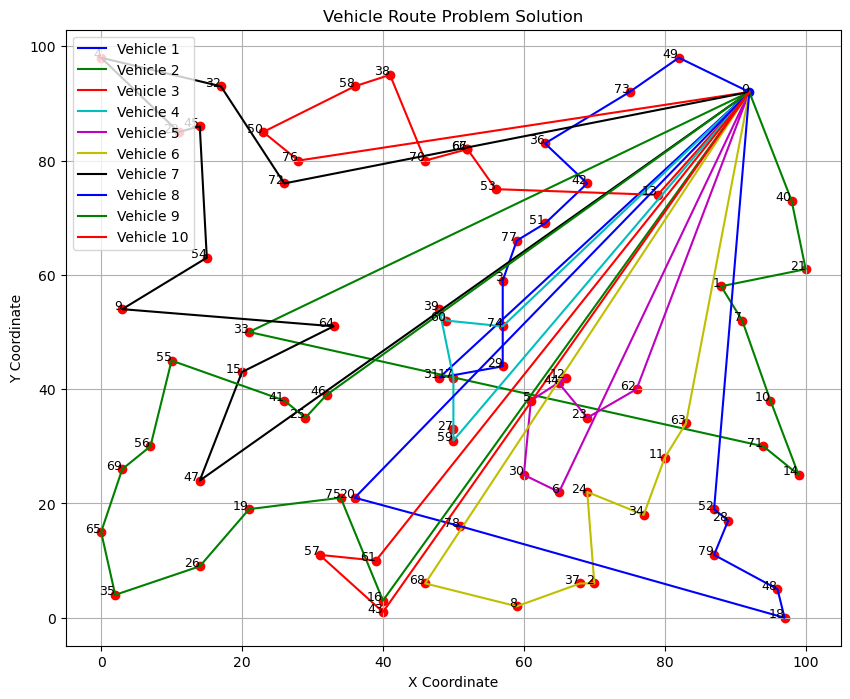

Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 100 <= 100
Vehicle 3 is within capacity constraint: 100 <= 100
Vehicle 4 is within capacity constraint: 99 <= 100
Vehicle 5 is within capacity constraint: 100 <= 100
Vehicle 6 is within capacity constraint: 99 <= 100
Vehicle 7 is within capacity constraint: 100 <= 100
Vehicle 8 is within capacity constraint: 100 <= 100
Vehicle 9 is within capacity constraint: 98 <= 100
Vehicle 10 is within capacity constraint: 46 <= 100


In [20]:

initial_routes = greedy_initial_solution()

optimized_routes = optimize_3_opt_routes_cvrp(initial_routes)

print("Optimized Routes for 3-opt: ", optimized_routes)

print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
plot_CVRP_solution(optimized_routes, node_coords)

# test the capacity constraint
test_capacity_constraint(optimized_routes, demands, vehicle_capacity)

In [ ]:
for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = cvrp_instance['edge_weight']
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    initial_routes = greedy_initial_solution()
    optimized_routes = optimize_routes_cvrp(initial_routes, distance_matrix)
    optimized_routes = optimize_3_opt_routes_cvrp(initial_routes)
    print("Optimized Routes for 3-opt: ", optimized_routes)

    print("Total Distance: ", total_distance(optimized_routes, distance_matrix))
    #plot_CVRP_solution(optimized_routes, node_coords)
    # test the capacity constraint
    test_capacity_constraint(optimized_routes, demands, vehicle_capacity)


===================== (Augerat et al, No of trucks: 5, Optimal value: 778) =====================
Number of Nodes: 34
Optimized Routes for 3-opt:  [[20, 26, 4, 33, 18, 2, 16, 22], [5, 30, 24, 27, 1, 29, 15], [10, 13, 7, 14, 6, 8, 11, 31], [21, 9, 12, 3, 32, 28], [23, 19, 17, 25]]
Total Distance:  944.1552361022948
Vehicle 1 is within capacity constraint: 98 <= 100
Vehicle 2 is within capacity constraint: 97 <= 100
Vehicle 3 is within capacity constraint: 99 <= 100
Vehicle 4 is within capacity constraint: 88 <= 100
Vehicle 5 is within capacity constraint: 78 <= 100
===================== (Augerat et al, No of trucks: 5, Optimal value: 784) =====================
Number of Nodes: 32
Optimized Routes for 3-opt:  [[30, 26, 16, 12, 1, 7, 14, 29, 22, 18], [24, 27, 20, 5, 25, 10, 8], [13, 21, 31, 19, 17, 3, 23], [6, 2, 28, 4, 11, 9], [15]]
Total Distance:  1146.399631725379
Vehicle 1 is within capacity constraint: 100 <= 100
Vehicle 2 is within capacity constraint: 97 <= 100
Vehicle 3 is within 

# 